### Bidiretional LSTM for Time Series Forecasting

Libs required:

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,4)

import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.layers import Dense, LSTM, Bidirectional
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import TimeseriesGenerator

#### Reading the data numerically:

In [2]:
features_train = pd.read_pickle('./dataset/completed_split/features_train.pkl')
et0_train = pd.read_pickle('./dataset/completed_split/label_train.pkl')

features_val = pd.read_pickle('./dataset/completed_split/features_val.pkl')
et0_val = pd.read_pickle('./dataset/completed_split/label_val.pkl')

features_test = pd.read_pickle('./dataset/completed_split/features_test.pkl')
et0_test = pd.read_pickle('./dataset/completed_split/label_test.pkl')

#### Reading the normalized data due to the fact that the data is on different scale.

In [3]:
features_norm_train = pd.read_pickle('./dataset/completed_split/normalized/features_norm_train.pkl')
et0_norm_train = pd.read_pickle('./dataset/completed_split/normalized/label_norm_train.pkl')

features_norm_val = pd.read_pickle('./dataset/completed_split/normalized/features_norm_val.pkl')
et0_norm_val = pd.read_pickle('./dataset/completed_split/normalized/label_norm_val.pkl')

features_norm_test = pd.read_pickle('./dataset/completed_split/normalized/features_norm_test.pkl')
et0_norm_test = pd.read_pickle('./dataset/completed_split/normalized/label_norm_test.pkl')

In [5]:
data1 = pd.concat([features_norm_train, et0_norm_train], axis=1)
data2 = pd.concat([features_norm_val, et0_norm_val], axis=1)
data3 = pd.concat([features_norm_test, et0_norm_test], axis=1)

data4 = pd.concat([features_norm_train, et0_norm_train], axis=1)
data5 = pd.concat([features_norm_val, et0_norm_val], axis=1)
data6 = pd.concat([features_norm_test, et0_norm_test], axis=1)

data7 = pd.concat([features_norm_train, et0_train], axis=1)
data8 = pd.concat([features_norm_val, et0_val], axis=1)
data9 = pd.concat([features_norm_test, et0_test], axis=1)

In [4]:
BATCH_SIZE = 32
N_INPUT = len(features_train)
N_FEATURES = len(features_train.columns)

In [11]:
data7.columns

Index(['ARM', 'ETR', 'Deficit', 'Excedente', 'PRECIPITACAO', 'TEMPERATURA',
       'ETo'],
      dtype='object')

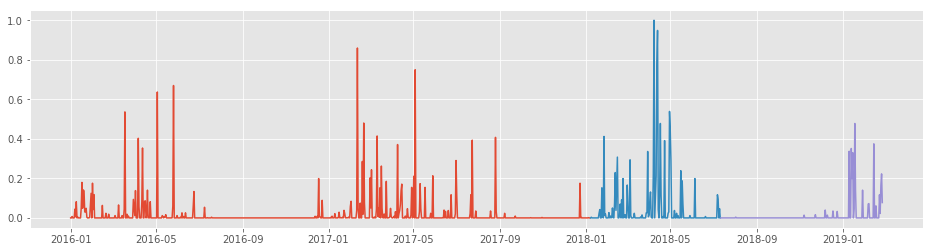

In [27]:
plt.plot(data7['PRECIPITACAO'])
plt.plot(data8['PRECIPITACAO'])
plt.plot(data9['PRECIPITACAO'])
plt.show()

#### Preprocess the data to a format a neural network can ingest.

We will use the following parameter values:

- lookback = 5, i.e. our observations will go back 5 days.
- steps = 1, i.e. our observations will be sampled at one data point per day.
- delay = 1, i.e. our targets will be 24 hours in the future.

In [65]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1 # max 288
    i = min_index + lookback # i= 0+5 = 5
    while 1:
        if i + batch_size >= max_index:
            i = min_index + lookback 
        rows = np.arange(i, min(i + batch_size, max_index)) 
        i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, targets

In [70]:
lookback = 5
step = 1
delay = 1
batch_size = 32

train_gen = generator(data7.values,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=None,
                      step=step, 
                      batch_size=batch_size) #(len(features_train)-1)

val_gen = generator(data8.values,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=None,
                    step=step,
                    batch_size=batch_size) #(len(features_val)-1)

test_gen = generator(data9.values,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=None,
                     step=step,
                     batch_size=batch_size) #(len(features_test)-1)

train_steps =  len(features_train) // batch_size

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps =  len(features_val) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = len(features_test) // batch_size

In [107]:
def overfitting_plot(history, name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training mae')
    plt.plot(epochs, val_loss, 'b', label='Validation mae')
    plt.title('Training and validation loss')
    plt.legend(loc='best')
    plt.savefig('loss_'+name+'.png') 

In [91]:
model = Sequential()
model.add(Bidirectional(LSTM(32, 
                             dropout=0.2,
                             recurrent_dropout=0.2),
                        input_shape=(None, data6.shape[-1]))) # 50
model.add(Dense(1))

# Stacking more layers
# model.add(Bidirectional(LSTM(32, 
#                              dropout=0.2, 
#                              recurrent_dropout=0.2, 
#                              return_sequences=True))) activation='relu'

#else:
#    model.add(Bidirectional(LSTM(32, activation='relu', input_shape=(N_INPUT, N_FEATURES))))
# input_shape=(None, float_data.shape[-1]

In [118]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae', 'mse'])
#testar Adam 1e-3 and 5e-4

In [119]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
23/23 [==============================] - 1s 60ms/step - loss: 1.5376 - mean_absolute_error: 1.5376 - mean_squared_error: 3.6897 - val_loss: 1.3591 - val_mean_absolute_error: 1.3591 - val_mean_squared_error: 3.0204
Epoch 2/40
23/23 [==============================] - 0s 8ms/step - loss: 1.5443 - mean_absolute_error: 1.5443 - mean_squared_error: 3.7829 - val_loss: 1.4044 - val_mean_absolute_error: 1.4044 - val_mean_squared_error: 3.0290
Epoch 3/40
23/23 [==============================] - 0s 9ms/step - loss: 1.4657 - mean_absolute_error: 1.4657 - mean_squared_error: 3.5418 - val_loss: 1.4019 - val_mean_absolute_error: 1.4019 - val_mean_squared_error: 3.0227
Epoch 4/40
23/23 [==============================] - 0s 8ms/step - loss: 1.5159 - mean_absolute_error: 1.5159 - mean_squared_error: 3.6438 - val_loss: 1.3978 - val_mean_absolute_error: 1.3978 - val_mean_squared_error: 3.0095
Epoch 5/40
23/23 [==============================] - 0s 8ms/step - loss: 1.5118 - mean_absolute_error: 1

23/23 [==============================] - 0s 11ms/step - loss: 1.4394 - mean_absolute_error: 1.4394 - mean_squared_error: 3.3444 - val_loss: 1.5002 - val_mean_absolute_error: 1.5002 - val_mean_squared_error: 3.3332
Epoch 38/40
23/23 [==============================] - 0s 10ms/step - loss: 1.4423 - mean_absolute_error: 1.4423 - mean_squared_error: 3.2988 - val_loss: 1.5318 - val_mean_absolute_error: 1.5318 - val_mean_squared_error: 3.4579
Epoch 39/40
23/23 [==============================] - 0s 9ms/step - loss: 1.4675 - mean_absolute_error: 1.4675 - mean_squared_error: 3.4346 - val_loss: 1.4051 - val_mean_absolute_error: 1.4051 - val_mean_squared_error: 2.9881
Epoch 40/40
23/23 [==============================] - 0s 9ms/step - loss: 1.4703 - mean_absolute_error: 1.4703 - mean_squared_error: 3.3993 - val_loss: 1.4559 - val_mean_absolute_error: 1.4559 - val_mean_squared_error: 3.1774


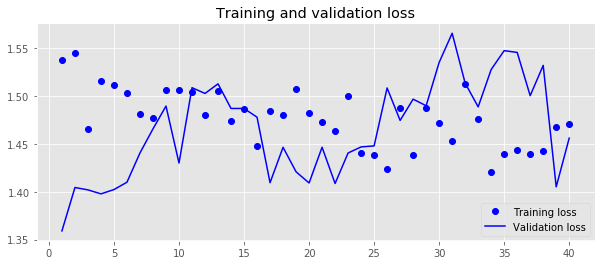

In [120]:
overfitting_plot(history, 'e001')

There are many other things you could try, in order to improve performance on the temperature-forecasting problem:
- Adjust the number of units in each recurrent layer in the stacked setup. The current choices are largely arbitrary and thus probably suboptimal.
- Adjust the learning rate used by the RMSprop optimizer. Change the optimizer to Adam.
- Try using LSTM layers instead of GRU layers (vice-versa).
- Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.
- Don’t forget to eventually run the best-performing models (in terms of validation MAE ) on the test set! Otherwise, you’ll develop architectures that are overfitting to the validation set.

In [121]:
model.save('./saved_models/e001.h5')

In [122]:
model.evaluate_generator(test_gen,steps=test_steps)

[1.6325380717005049, 1.6325380717005049, 4.1739006723676413]

In [123]:
np.sqrt(4.1739006723676413)

2.0430126461594997

* MAE  = 1.6325380717005049

* RMSE = 2.0430126461594997